In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython import get_ipython
ipython = get_ipython()

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Suppress rpy2 runtime warnings
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
%%R

# Visualization
library(ggplot2)
library(ggalt)
library(ggExtra)
library(ggcorrplot)
library(ggthemes)
library(ggdendro)
library(GGally)
library(ggrepel)
theme_set(theme_light())

# Tidyverse library
library(scales)
library(dplyr)
library(tidyr)
library(forcats)
library(readr)
library(purrr)

# String manipulations
library(tools)
library(lubridate)

# Machine Learning Related
library(car)
library(caTools)
library(pROC)

# Misc
library(psych)
library(mice)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: Error in library(ggalt) : there is no package called ‘ggalt’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(ggalt) : there is no package called ‘ggalt’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


In [3]:
# 1a. Import the dataset and train-test split

crime = pd.read_csv('../../Homework Data/Homework 4 Data/communities.csv', na_values='?')
crime = crime.iloc[:, 5:] # Drop the first five non-predictive columns

In [4]:
# Train-test split

train = crime.iloc[:1495, :]
test = crime.iloc[1495:, :]
X_train = train.iloc[:, :122]
y_train = train.iloc[:, 122]
X_test = test.iloc[:, :122]
y_test = test.iloc[:, 122]

In [5]:
# 1b. Data imputation

Here we will use the **MICE** (Multivariate Imputation By Chained Equations) package. Note that **the train and test set imputations are done separately** to avoid data leakage. By doing so, the test set provides a more reliable evaluation on the performance of the train set.

In [6]:
%%R -i X_train,X_test -o impped_train,impped_test

imp_train = mice(X_train,
                 m=20, # 20 iterations
                 defaultMethod='pmm') # Use predictive mean matching since all variables are numerical

imp_test = mice(X_test,
                m=20,
                defaultMethod='pmm')

impped_train = complete(imp_train)
impped_test = complete(imp_test)


 iter imp variable
  1   1  OtherPerCap  LemasSwornFT  LemasSwFTPerPop  LemasSwFTFieldOps  LemasSwFTFieldPerPop  LemasTotalReq  LemasTotReqPerPop  PolicReqPerOffic  RacialMatchCommPol  PctPolicWhite  PctPolicBlack  PctPolicHisp  PctPolicAsian  PctPolicMinor  OfficAssgnDrugUnits  NumKindsDrugsSeiz  PolicAveOTWorked  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  LemasGangUnitDeploy  PolicBudgPerPop
  1   2  OtherPerCap  LemasSwornFT  LemasSwFTPerPop  LemasSwFTFieldOps  LemasSwFTFieldPerPop  LemasTotalReq  LemasTotReqPerPop  PolicReqPerOffic  RacialMatchCommPol  PctPolicWhite  PctPolicBlack  PctPolicHisp  PctPolicAsian  PctPolicMinor  OfficAssgnDrugUnits  NumKindsDrugsSeiz  PolicAveOTWorked  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  LemasGangUnitDeploy  PolicBudgPerPop
  1   3  OtherPerCap  LemasSwornFT  LemasSwFTPerPop  LemasSwFTFieldOps  LemasSwFTFieldPerPop  LemasTotalReq  LemasTotReqPerPop  PolicReqPerOffic  RacialMatchCommPol  PctPolicWhite  PctPolicBlack  PctPolicHisp  PctPol

In [7]:
# Keep separate sets for imputed data

X_train_imp = impped_train.drop('PolicPerPop', axis=1) # The MICE imputation has failed to impute this
                                                       # variable for some reasons.
X_test_imp = impped_test.drop('PolicPerPop', axis=1)

In [8]:
# 1c. Correlation plot

X_cor = X_train_imp.corr()

In [9]:
%%R -i X_cor

# Plot
gg=ggcorrplot(X_cor, 
              hc.order = TRUE, # Use hierachical clustering to order the variables
              type = "lower",
              outline.col='white',
              colors = c("tomato2", "white", "springgreen3"),
              legend.title='Correlation',
              title="Correlogram of training set features",
              ggtheme=theme_classic,
              tl.cex=7.5, # Variable name size
              tl.srt=90) # Variable name rotation on the x-axis

png(file='./HW4_image/corr.png', width=1000, height=1000)
gg

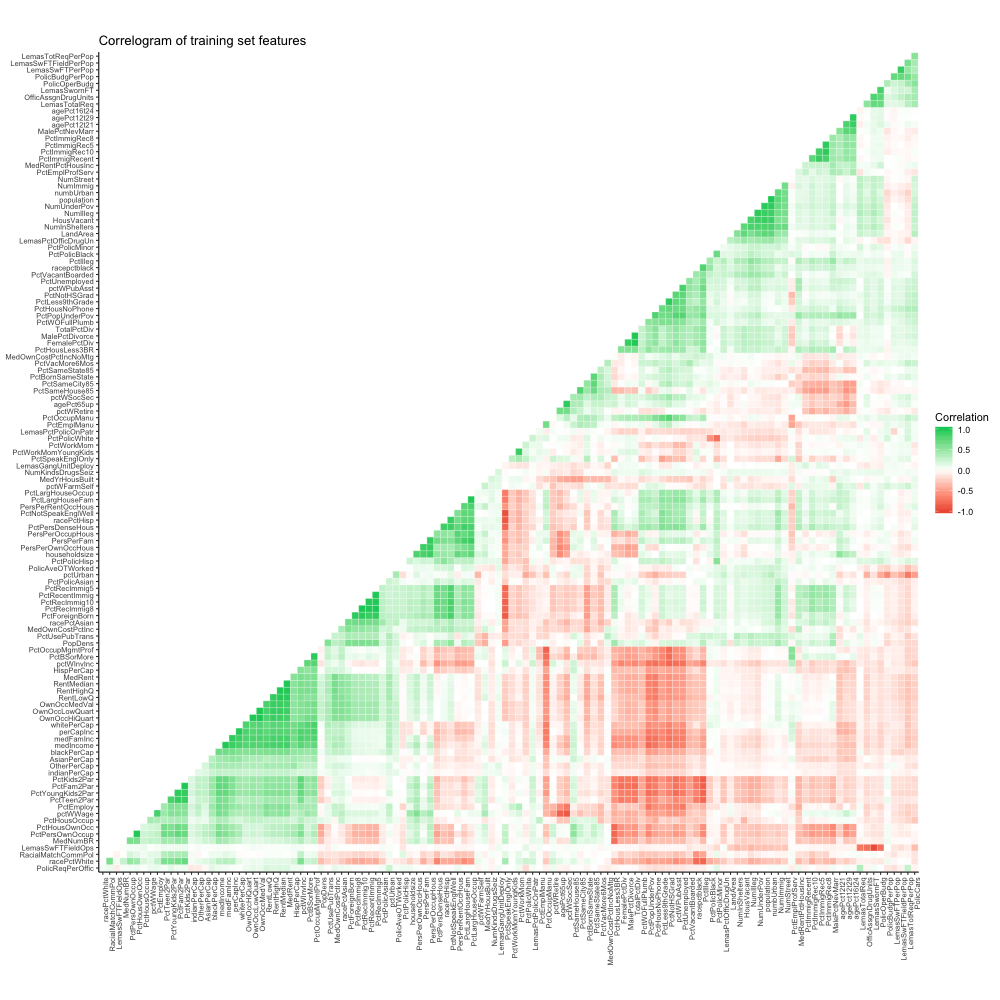

In [10]:
Image('./HW4_image/corr.png')

In [11]:
# 1d. Coefficient of Variation

COV = X_train_imp.apply(lambda x: np.std(x)/np.mean(x)).sort_values(ascending=False)
COV.head(20)

NumStreet             4.291
NumInShelters         3.470
NumIlleg              3.058
NumImmig              2.926
PctPolicAsian         2.751
LemasPctOfficDrugUn   2.552
NumUnderPov           2.342
population            2.240
numbUrban             2.038
HousVacant            1.968
LandArea              1.645
racePctHisp           1.612
PctNotSpeakEnglWell   1.456
OfficAssgnDrugUnits   1.445
racepctblack          1.428
PctUsePubTrans        1.397
LemasSwornFT          1.386
racePctAsian          1.359
PctRecentImmig        1.288
PctRecImmig5          1.286
dtype: float64

In [12]:
# 1e. Scatterplot and boxplot for high CV variables

colnames_11 = COV.head(11).index
highCV_11 = pd.concat([X_train_imp.loc[:, COV.head(11).index], y_train], axis=1)

In [13]:
%%R -i highCV_11,colnames_11

g = highCV_11 %>%
    gather(-one_of('ViolentCrimesPerPop'), key='variable', value='value')

g$variable = ordered(g$variable, levels=colnames_11)

gg=ggplot(g, aes(variable, value)) +
     geom_boxplot(outlier.shape=NA) +
     geom_jitter(aes(col=ViolentCrimesPerPop), width=.05) +
     scale_color_gradient(low='blue', high='red') +
     theme(axis.text.x = element_text(angle=45, vjust=0.5)) +
     labs(title="Distribution of features with top 11 CV",
          x="Variable",
          y="Normalized Violent Crime per Population",
          color='Violent Crimes per Population')

png(file='./HW4_image/scatter.png', width=800, height=600)
gg

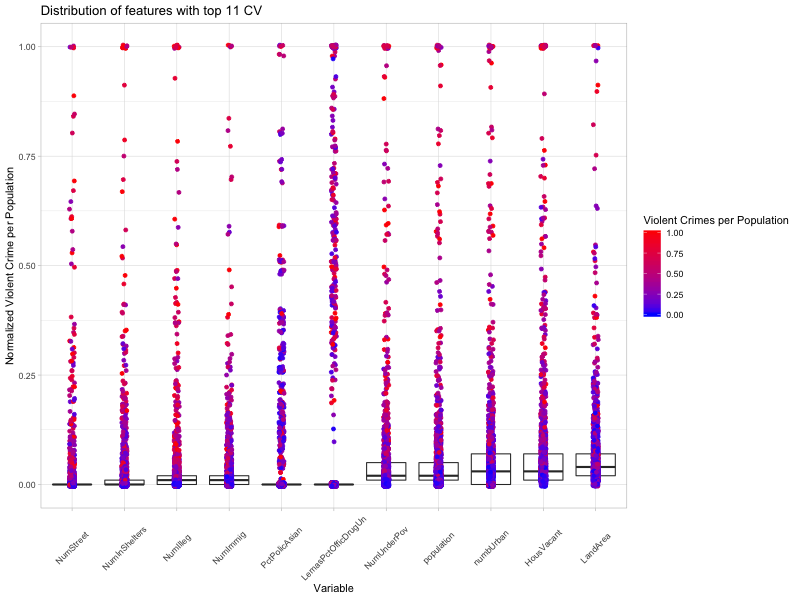

In [14]:
Image('./HW4_image/scatter.png')

CV measures the standard deviation dispersed over mean. The above variables has such high CVs presumably because of their **relatively small means**, as reflected by the box-plots and clustering of samples within the lower region of the diagram.

The target variable is also dispersed quite evenly along the y-axis for each variable, each with a not so very apparent positive trend. It is hard to draw any conclusions about the significance of those features at this stage.

In [15]:
# 1f. simple linear regression

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_imp, y_train)
1 - linreg.score(X_test_imp, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

0.5189669238802597

The test error is quite terrible at a 0.519 with linear regression here. 

Note that 1 - R^2 is used for the rest of the exercise as a measure to compare test errors.

In [30]:
# 1g. Ridge Regression

from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(0,1,200),
                cv=5)
ridge.fit(X_train_imp, y_train)
ridge.alpha_ # Get the estimated alpha
1 - ridge.score(X_test_imp, y_test)

RidgeCV(alphas=array([ 1.        ,  1.01163798,  1.0234114 ,  1.03532184,  1.0473709 ,
        1.05956018,  1.07189132,  1.08436597,  1.0969858 ,  1.1097525 ,
        1.12266777,  1.13573336,  1.148951  ,  1.16232247,  1.17584955,
        1.18953407,  1.20337784,  1.21738273,  1.2315506 ,  1.24588336,
        1.26038293,  1.27505124,  1.28989026,  1.30490198,  1.3200884 ,
        1.33545156,  1.35099352,  1.36671636,  1.38262217,  1.3987131 ,
        1.4149913 ,  1.431...
        7.57525026,  7.66341087,  7.75259749,  7.84282206,  7.93409667,
        8.02643352,  8.11984499,  8.21434358,  8.30994195,  8.40665289,
        8.50448934,  8.60346442,  8.70359136,  8.80488358,  8.90735464,
        9.01101825,  9.1158883 ,  9.22197882,  9.32930403,  9.43787828,
        9.54771611,  9.65883224,  9.77124154,  9.88495905, 10.        ]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

2.273965752357928

0.3858325897495667

The chosen alpha with a 5-fold cross-validation is 2.274, which gives a test error of 0.386, quite an improvement compared to the un-regularized model!

In [34]:
# 1h. Lasso Regression

from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5,
                n_alphas=500,
                max_iter=5000)

lasso.fit(X_train_imp, y_train)
lasso.alpha_
1 - lasso.score(X_test_imp, y_test)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=500, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

0.00011359342784569256

0.3745079403307231

The chosen alpha is 0.000114, which gives a test error of 0.375, which is slightly better than Ridge's.

In [38]:
# Selected variables by Lasso with non-standardized features

X_train_imp.columns[np.where(lasso.coef_!=0)]

Index(['racepctblack', 'racePctAsian', 'racePctHisp', 'agePct12t21',
       'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf',
       'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap',
       'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap',
       'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctUnemployed',
       'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce',
       'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par',
       'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10',
       'PctRecImmig10', 'PctNotSpeakEnglWell', 'PctLargHouseOccup',
       'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant',
       'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt',
       'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ',
       'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
       'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStre

In [39]:
# Repeat Lasso with standardized features

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_imp_std = std.fit_transform(X_train_imp)
X_test_imp_std = std.fit_transform(X_test_imp)

lasso = LassoCV(cv=5,
                n_alphas=500,
                max_iter=5000)

lasso.fit(X_train_imp_std, y_train)
lasso.alpha_
1 - lasso.score(X_test_imp_std, y_test)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=5000, n_alphas=500, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

0.0006043360519609525

0.37651222338957113

The chosen alpha is 0.0006, which gives a test error of 0.377, which is essentially the same as the previous Lasso with non-standardized features. This **result is expected** because the data has already been normalized before, it is technically redundant to perform standardization again.

In [41]:
# Selected variables by Lasso with standardized features

X_train_imp.columns[np.where(lasso.coef_!=0)]

Index(['population', 'racepctblack', 'racePctAsian', 'agePct12t21',
       'agePct12t29', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf',
       'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'whitePerCap',
       'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap',
       'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctUnemployed',
       'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce',
       'MalePctNevMarr', 'FemalePctDiv', 'PctKids2Par', 'PctYoungKids2Par',
       'PctTeen2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig',
       'PctImmigRec10', 'PctRecImmig10', 'PctNotSpeakEnglWell',
       'PctLargHouseOccup', 'PersPerOccupHous', 'PctPersOwnOccup',
       'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup',
       'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt',
       'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'RentLowQ',
       'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
       'MedOwnCo

The features selected by both methods are the same for the most part.

In [66]:
# 1i. Principal Component Regression

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline # Combine pipeline with GridSearch for elegant code :)
from sklearn.model_selection import GridSearchCV

steps = [
    ('pca', PCA()),
    ('linreg', LinearRegression())
]

pipeline = Pipeline(steps)

parameters = {
    'pca__n_components': range(1,122) # Test all possible combinations of principal components
}

pcr = GridSearchCV(pipeline, 
                   parameters,
                   cv=5) # 5-fold cross-validation
pcr.fit(X_train_imp, y_train)
1 - pcr.best_score_
pcr.best_params_
1 - pcr.score(X_test_imp, y_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('linreg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'pca__n_components': range(1, 122)},
             pre_dispatch='2

0.34677052962145893

{'pca__n_components': 95}

0.6149194377507983

The best number of principal components is found to be 95. The test error is abhorrent, sitting at 0.615. The fact that **such a large number of principal components being used is a flag for the inappropriateness of PCR** on this dataset.

In [85]:
# 1j. XGBoost with Bayesian Optimization

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials # Employ informed search technique to prevent 
                                                      # hyperparameter space explosion!
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Set up DMatrix to optimize performance
dtrain = xgb.DMatrix(data=X_train, label=y_train) # We will exploit the fact that XGboost is able to 
                                                  # handle missing values, and use original dataset here
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Set up space dictionary with specified hyperparameters
space = {'max_depth'        : hp.choice('max_depth', np.arange(3, 8, dtype=int)),
         'learning_rate'    : hp.uniform('learning_rate', 0.001, 0.1),
         'subsample'        : hp.uniform('subsample', 0.5, 1),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01), # Note the use of quantile uniforms
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),     # which can be understood as binned
         'alpha'            : hp.uniform('alpha', 0, 1),
         'lambda'           : hp.uniform('lambda', 0, 1),
         'gamma'            : hp.uniform('gamma', 0, 1)}

# Set up objective function
def objective(params):
    params = {'max_depth'        : params['max_depth'], 
              'learning_rate'    : params['learning_rate'],
              'subsample'        : params['subsample'], # Subsample ratio of the training instances
              'colsample_bytree' : params['colsample_bytree'], # Number of columns used for splitting by tree
              'min_child_weight' : params['min_child_weight'], # Minimum sum of instance weight needed in a child
              'alpha'            : params['alpha'], # L1 regularization term
              'lambda'           : params['lambda'], # L2 regularization term
              'gamma'            : params['gamma'], # Min_split_loss
              'objective'        : 'reg:squarederror', # Squared Loss
              'eval_metric'      : 'rmse', # Use RMSE as evaluation metric
              'seed'             : 408, # Set seed for reproducible result (for fold generation)
              'silent'           : 1,
              'nthread'          : -1} # Use all available cores
                              
    res = xgb.cv(xgb.XGBRegressor(**params).get_params(), # Dictionary unpacking
                 dtrain, 
                 num_boost_round=10000, # Build a huge numbers of trees, then perform early stopping :)
                 nfold=5, # 5-fold cross-validation
                 early_stopping_rounds=50)
    
    return np.min(res['test-rmse-mean']) # The objective for Hyperopt to minimize is the extracted
                                         # lowest mean test rmse from the res dataframe

trials = Trials()

# Run the algorithm
best = fmin(fn=objective,
            space=space, 
            max_evals=100, # Control how many evaluations to take
            rstate=np.random.RandomState(408), # Optional for consistency
            trials=trials,
            algo=tpe.suggest) # Tree-structured Parzen Estimator (TPE) algorithm

best

100%|██████████| 100/100 [38:25<00:00, 19.71s/it, best loss: 0.137409]         


{'alpha': 0.13452382701559307,
 'colsample_bytree': 0.13,
 'gamma': 0.12452944273315986,
 'lambda': 0.27088247227384876,
 'learning_rate': 0.022802331977312372,
 'max_depth': 4,
 'min_child_weight': 9.0,
 'subsample': 0.588324892683006}

In [86]:
res = xgb.cv(xgb.XGBRegressor(**best, seed=408, nthread=-1, silent=1).get_params(), 
             dtrain, num_boost_round=10000, nfold=10, # Again, determine the number of trees built 
             early_stopping_rounds=50)                # using the tuned parameters and 10-fold cross-validation
                                                      # with early stopping
N_ESTIMATOR = res.shape[0] - 50

In [87]:
xgbreg = xgb.XGBRegressor(**best, n_estimators=N_ESTIMATOR, objective='reg:squarederror')
xgbreg.fit(X_train, y_train)
1 - xgbreg.score(X_test, y_test)

XGBRegressor(alpha=0.13452382701559307, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.13,
             gamma=0.12452944273315986, importance_type='gain',
             lambda=0.27088247227384876, learning_rate=0.022802331977312372,
             max_delta_step=0, max_depth=4, min_child_weight=9.0, missing=None,
             n_estimators=391, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.588324892683006, verbosity=1)

0.33410163713588514

We arrive at a test error of 0.334 with the optimized hyperparameters obtained from Bayesian Optimization. **This is a substantial improvement from the regularized linear models!**

Bayesian model-based optimization means **constructing a probability model $p(y | x)$ of the objective function and updating this model as more information is collected.** As the number of evaluations increases, the model (also called a surrogate function) becomes a more accurate representation of the objective function and **the algorithm spends more time evaluating promising values.** It allows us to search on a continuous scale instead of pre-defined grid as in the case of GridSearch or RandomSearch!

Specifically, **the chosen alpha is 0.135,** along with the rest of the **seven tuned hyperparemeters!** In addition, the optimal **number of trees to be built is determined by setting an arbitrarily insane amount of trees with early stopping using cross-validation.** All of them essentially controls for over-fitting.

Note that **we did not perform any missing value imputation**. Instead, XGBoost treats the missing values as **Missing At Random** (i.e. missing for a reason) and **automatically assigns the missing values to one or the other side at node splittings** for the greatest reduction in RSS (or greatest information gain in classification setting). This is very handy!

The only drawback is that the tuning process took relatively long, and in our case it took almost 40 minutes :(

The other parts of the homework is contained in Homework 4b & 4c :)